In [153]:
from pathlib import Path
from tqdm import tqdm
from fdiff.utils.fourier import dft

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

DATA_FILEPATH = PATH_DOWNLOAD = Path.cwd() / "../data/nasa/"


In [154]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    "patrickfleith/nasa-battery-dataset", path = PATH_DOWNLOAD, unzip=True
)

In [155]:
# Read the metadata
metadata = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "metadata.csv")

In [156]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [232]:
# Extract the list of filenames which correspond to type=charge
charge_files = metadata[metadata["type"] == "charge"]["filename"].values
print("Number of charge files: ", len(charge_files))
discharge_files = metadata[metadata["type"] == "discharge"]["filename"].values
print("Number of discharge files: ", len(discharge_files))
impedance_files = metadata[metadata["type"] == "impedance"]["filename"].values
print("Number of impedance files: ", len(impedance_files))

Number of charge files:  2815
Number of discharge files:  2794
Number of impedance files:  1956


In [251]:
#Discharge

example_discharge_file = discharge_files[-40]
print(example_discharge_file)
data_example = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "data"/example_discharge_file)
data_example.head()

#Print maximum time interval
print("Maximum time interval: ", data_example["Time"].diff().max())

#Print maximum time
print("Maximum time: ", data_example["Time"].max())

07466.csv
Maximum time interval:  12.375
Maximum time:  2416.672


100%|██████████| 2794/2794 [00:02<00:00, 1025.38it/s]


Proportion of files with maximum time greater than 6000:  0.07050823192555476
Number of files with maximum time greater than 6000:  197


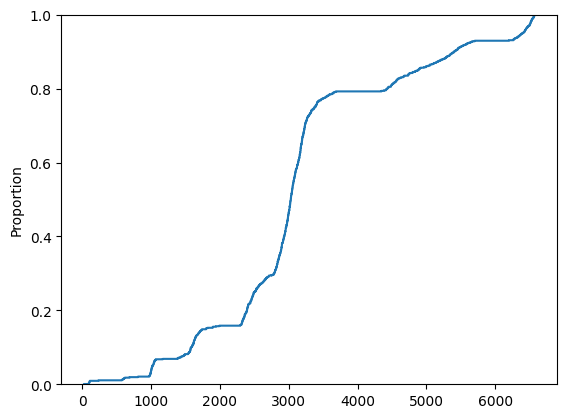

In [253]:
# Loop over all the charge files and extract the maximum time
max_times = []
interval_times = []
for filename in tqdm(discharge_files):
    data = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "data"/filename)
    max_times.append(data["Time"].max())
    interval = data_example["Time"].diff().max()
    interval_times.append(interval)

#Plot the CDF of the maximum time

sns.ecdfplot(max_times)
# Check the proportion of files which have a maximum time greater than 6000
print("Proportion of files with maximum time greater than 6000: ", np.mean(np.array(max_times) > 6000))
print("Number of files with maximum time greater than 6000: ", np.sum(np.array(max_times) > 6000))

In [250]:
#Now investigate the first charge file
example_charge_file = charge_files[0]
print(example_charge_file)
data_example = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "data"/example_charge_file)
data_example.head()

#Print maximum time interval
print("Maximum time interval: ", data_example["Time"].diff().max())

00003.csv
Maximum time interval:  7.531999999999243


100%|██████████| 2815/2815 [00:06<00:00, 432.94it/s]

Proportion of files with maximum time greater than 6000:  0.9801065719360569
Number of files with maximum time greater than 6000:  2759


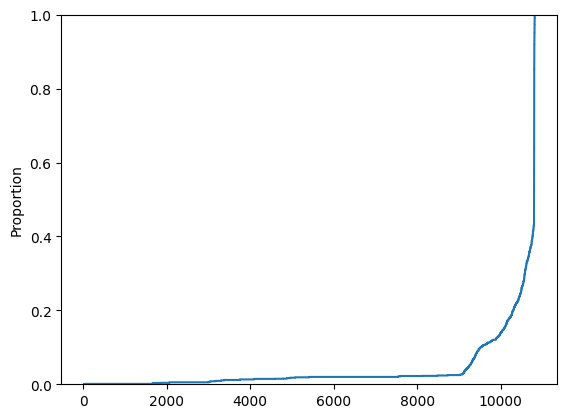

In [252]:
# Loop over all the charge files and extract the maximum time
max_times = []
interval_times = []
for filename in tqdm(charge_files):
    data = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "data"/filename)
    max_times.append(data["Time"].max())
    interval = data_example["Time"].diff().max()
    interval_times.append(interval)

#Plot the CDF of the maximum time

sns.ecdfplot(max_times)
# Check the proportion of files which have a maximum time greater than 6000
print("Proportion of files with maximum time greater than 6000: ", np.mean(np.array(max_times) > 6000))
print("Number of files with maximum time greater than 6000: ", np.sum(np.array(max_times) > 6000))

In [ ]:
#Plot "Voltage_measured vs Time"
sns.lineplot(data=data_example, x="Time", y="Voltage_charge")

In [ ]:
bin_size = 10  # You can adjust this to your desired bin size in minutes
data_example['Time_Bin'] = pd.cut(data_example['Time'], bins=range(0, int(data_example['Time'].max()) + bin_size, bin_size))

# Group by custom bins and calculate the mean for each group
result_df = data_example.groupby('Time_Bin').mean().reset_index()


In [ ]:
result_df.head()


In [ ]:
# Replace the Time_BIn by the index of the bin
result_df['Time_Bin'] = result_df.index
print("number of time steps", len(result_df))


In [ ]:
sns.lineplot(data=result_df, x="Time_Bin", y="Voltage_charge")
plt.show()
sns.lineplot(data=data_example, x="Time", y="Voltage_charge")
plt.show()
#Notice that the first peak is reduced because of binning

sns.lineplot(data=result_df, x="Time_Bin", y="Voltage_measured")
plt.show()
sns.lineplot(data=data_example, x="Time", y="Voltage_measured")
plt.show()

# Full preprocessing script

In [277]:
SUBDATASET = "charge"
if SUBDATASET == "discharge":
    INTERVAL_BIN = 15
    CUTOFF_TIME = 2000- 2000%INTERVAL_BIN
    files = discharge_files
    features = [
            "Voltage_measured",
            "Current_measured",
            "Temperature_measured",
            "Current_load",
            "Voltage_load",
        ]
elif SUBDATASET == "charge":
    INTERVAL_BIN = 10
    CUTOFF_TIME = 5000- 5000%INTERVAL_BIN
    files = charge_files
    features = [
            "Voltage_measured",
            "Current_measured",
            "Temperature_measured",
            "Current_charge",
            "Voltage_charge",
        ]


else:
    raise ValueError("SUBDATASET must be either 'discharge' or 'charge'")





full_df = pd.DataFrame()

for filename in tqdm(files):
    data = pd.read_csv(PATH_DOWNLOAD / "cleaned_dataset"/ "data"/filename)
    
    #check if the maximum time is greater than the cutoff time
    if data["Time"].max() > CUTOFF_TIME:
        #Check that the maximu interval is less than 10
        interval = data["Time"].diff().max()
        if interval > INTERVAL_BIN:
            continue
        
        
        # Remove the rows such that the time is greater than the cutoff time
        data = data[data["Time"] < CUTOFF_TIME]
        
        #bin the data
        
        data['Time_Bin'] = pd.cut(data['Time'], bins=range(-INTERVAL_BIN, int(CUTOFF_TIME + INTERVAL_BIN), INTERVAL_BIN))
        
             
        # Group by custom bins and calculate the mean for each group
        result_df = data.groupby('Time_Bin', observed=False).mean().reset_index()
        result_df['Time_Bin'] = result_df.index
        
        result_df["filename"] = filename
        full_df = pd.concat([full_df, result_df])        
        
        




100%|██████████| 2815/2815 [00:49<00:00, 57.19it/s] 


In [280]:
CUTOFF_TIME//INTERVAL_BIN + 1

501

In [278]:
df_pivot = full_df.pivot(index='filename', columns='Time_Bin', values=features)

In [279]:
df_pivot

Voltage_measured                                                    \
Time_Bin               0         1         2         3         4         5     
filename                                                                       
00003.csv         3.486189  3.761015  3.794844  3.819232  3.840722  3.860581   
00006.csv         3.252719  3.528699  3.593447  3.637585  3.675045  3.707003   
00008.csv         3.255399  3.533031  3.600614  3.646405  3.685240  3.718192   
00010.csv         3.302855  3.576175  3.639267  3.681733  3.718126  3.748696   
00012.csv         3.325621  3.595059  3.656386  3.698105  3.733366  3.763297   
...                    ...       ...       ...       ...       ...       ...   
07555.csv         3.745490  3.941112  3.958164  3.969669  3.981883  3.992027   
07557.csv         3.749292  3.941311  3.958447  3.969719  3.981986  3.991920   
07560.csv         3.782642  4.003709  4.019798  4.030551  4.042122  4.051268   
07563.csv         3.738696  3.931820  3.949232  3.960585  3.973192  3.981278   
07565.csv         3.742571  3.932574  3.949894  3.961110  3.973335  3.981243   

                                                   ... Voltage_charge         \
Time_Bin        6         7         8         9    ...            491    492   
filename                                           ...                         
00003.csv  3.884060  3.900672  3.915742  3.929804  ...          4.402  4.402   
00006.csv  3.743988  3.768575  3.790718  3.811145  ...          4.402  4.402   
00008.csv  3.756114  3.781497  3.804007  3.824655  ...          4.402  4.402   
00010.csv  3.784452  3.808230  3.829422  3.848801  ...          4.402  4.402   
00012.csv  3.798263  3.821258  3.841889  3.860727  ...          4.390  4.390   
...             ...       ...       ...       ...  ...            ...    ...   
07555.csv  3.998773  4.005147  4.012518  4.019170  ...          4.326  4.326   
07557.csv  3.998446  4.004594  4.011804  4.016855  ...          4.326  4.326   
07560.csv  4.057269  4.062135  4.068375  4.072317  ...          4.339  4.339   
07563.csv  3.988229  3.996924  4.002770  4.008220  ...          4.326  4.326   
07565.csv  3.988141  3.996554  4.004150  4.009119  ...          4.326  4.326   

                                                                   
Time_Bin     493    494    495    496    497    498    499    500  
filename                                                           
00003.csv  4.402  4.402  4.402  4.402  4.402  4.402  4.402  4.402  
00006.csv  4.402  4.402  4.402  4.402  4.402  4.402  4.402  4.402  
00008.csv  4.402  4.402  4.402  4.402  4.402  4.402  4.402  4.402  
00010.csv  4.402  4.402  4.402  4.390  4.390  4.390  4.390  4.390  
00012.csv  4.390  4.390  4.390  4.390  4.390  4.390  4.377  4.377  
...          ...    ...    ...    ...    ...    ...    ...    ...  
07555.csv  4.326  4.326  4.326  4.326  4.326  4.326  4.326  4.326  
07557.csv  4.326  4.326  4.326  4.326  4.326  4.326  4.326  4.326  
07560.csv  4.339  4.339  4.339  4.339  4.339  4.339  4.339  4.339  
07563.csv  4.326  4.326  4.326  4.326  4.326  4.326  4.326  4.326  
07565.csv  4.326  4.326  4.326  4.326  4.326  4.326  4.326  4.326  

[2663 rows x 2505 columns]

In [207]:
X = torch.tensor(df_pivot.values, dtype=torch.float32)


In [214]:
#Rearange to get a 3D tensor of shape (num_samples, num_timesteps, num_features)
N_TIMESTEPS = 501
X_reshaped = X.reshape(X.shape[0], -1, N_TIMESTEPS)
#Permute the last two dimensions
X_charge = X_reshaped.permute(0, 2, 1)
print(X_charge[1])


tensor([[ 3.2527e+00, -2.3061e-03,  1.0146e+01, -6.0000e-04,  2.0000e-03],
        [ 3.5287e+00,  1.4904e+00,  1.0098e+01,  1.4995e+00,  4.4465e+00],
        [ 3.5934e+00,  1.4906e+00,  1.0031e+01,  1.4995e+00,  4.5170e+00],
        ...,
        [ 4.2108e+00,  2.9017e-01,  5.6513e+00,  2.9270e-01,  4.4020e+00],
        [ 4.2109e+00,  2.8910e-01,  5.6444e+00,  2.9210e-01,  4.4020e+00],
        [ 4.2111e+00,  2.8991e-01,  5.6553e+00,  2.9185e-01,  4.4020e+00]])


Text(0, 0.5, 'Singular value')

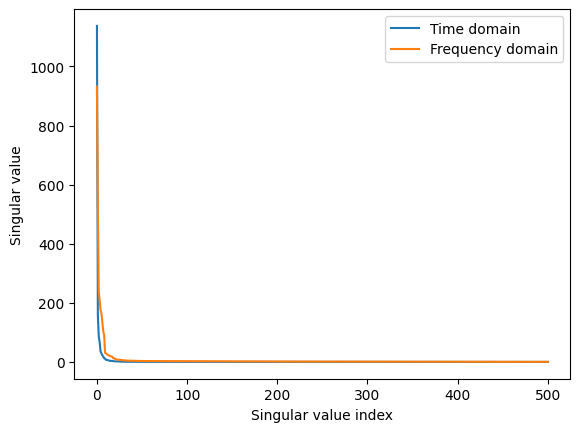

In [193]:
import matplotlib.pyplot as plt

X_train_reduced = X_charge[:, :, :1]
X_norm = (X_train_reduced - X_train_reduced.mean(dim=0, keepdim=True)) / X_train_reduced.std(dim=0, keepdim=True)
X_dft = dft(X_train_reduced)
X_norm_dft = (X_dft - X_dft.mean(dim=0, keepdim=True)) / X_dft.std(dim=0, keepdim=True)

sns.lineplot(torch.svd(X_norm.flatten(start_dim=1))[1], label="Time domain")
sns.lineplot(torch.svd(X_norm_dft.flatten(start_dim=1))[1], label="Frequency domain")
plt.legend()
plt.xlabel("Singular value index")
plt.ylabel("Singular value")